In [1]:
import torch
import torch.nn as nn
import lightly
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import yaml
import torch.nn.functional as F

from models import MomentumBT
from utils import data_helper, knn_predict
from tqdm.notebook import tqdm

In [75]:
conv1 = nn.Conv2d(3,3,1,bias=False)
weight = torch.tensor([[0.299,0.587,0.114],[-0.45, -0.883, 1.333],[-1.333, 1.116, 0.217]]).reshape(3,3,1,1)
weight = weight.expand(conv1.weight.size())
conv1.weight = torch.nn.Parameter(weight)

In [20]:
config_path = "./config.yaml"
with open(config_path, 'r') as stream:
    config = yaml.safe_load(stream)

In [21]:
pl.seed_everything(config['seed'])

gpus = 1 if torch.cuda.is_available() else 0
device = 'cuda' if gpus else 'cpu'

dataloader_train_ssl, dataloader_train_kNN, dataloader_test = data_helper(config)
model = MomentumBT(config, dataloader_train_kNN, gpus=gpus)

Global seed set to 1


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [41]:
check_path = "/home/shkhrmohan94_gmail_com/barlowtwins/wandb/run-20210617_214655-5ubyyzlc/files/mlo-ssl/5ubyyzlc/checkpoints/epoch=799-step=77599.ckpt"

In [51]:
(x, _), _, _ = iter(dataloader_train_ssl).next()

In [55]:
import matplotlib.pyplot as plt
from utils import rgb_to_ydbdr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


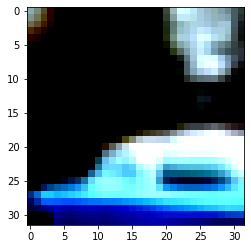

In [54]:
plt.imshow(x[0].permute(1,2,0).numpy())

In [79]:
out = conv1(x)

In [64]:
from skimage.color import ydbdr2rgb

In [80]:
out2 = ydbdr2rgb(out[0].permute(1,2,0).detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


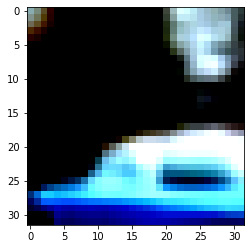

In [81]:
plt.imshow(out2)

In [42]:
model = model.load_from_checkpoint(check_path, config=config, dataloader_kNN=dataloader_train_kNN, gpus=gpus).cuda()

In [43]:
polyak_backbone = model.resnet_mmt_bt.momentum_backbone
resnet_backbone = model.resnet_mmt_bt.backbone

In [53]:
def prepare_kNN(backbone):
    backbone.eval()
    feature_bank = []
    targets_bank = []
    with torch.no_grad():
        for data in tqdm(dataloader_train_kNN):
            img, target, _ = data
            if gpus > 0:
                img = img.cuda()
                target = target.cuda()
            feature = backbone(img).squeeze()
            feature = F.normalize(feature, dim=1)
            feature_bank.append(feature)
            targets_bank.append(target)
    feature_bank = torch.cat(feature_bank, dim=0).t().contiguous()
    targets_bank = torch.cat(targets_bank, dim=0).t().contiguous()

    return feature_bank, targets_bank

In [54]:
def test_accuracy(backbone):
    feature_bank, targets_bank = prepare_kNN(resnet_backbone)
    num, top1 = 0, 0
    with torch.no_grad():
        for batch in tqdm(dataloader_test):
            images, targets, _ = batch
            images, targets = images.cuda(), targets.cuda()
            feature = backbone(images).squeeze()
            feature = F.normalize(feature, dim=1)
            pred_labels = knn_predict(feature, feature_bank, targets_bank, config['classes'], config['knn_k'], config['knn_t'])
            num += images.size(0)
            top1 += (pred_labels[:, 0] == targets).float().sum().item()
    return (num, top1)

In [55]:
res_acc = test_accuracy(resnet_backbone)
pol_acc = test_accuracy(polyak_backbone)

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [56]:
print(res_acc[1]/res_acc[0])
print(pol_acc[1]/pol_acc[0])

0.8479
0.8408


In [52]:
acc_polyak = top1/num
print(acc_polyak)

0.8408


In [4]:
batch = None
for batch in dataloader_train_ssl:
    break
x0, x1 = batch[0]
x00 = x0[:,0].unsqueeze(1)

In [5]:
resnet = lightly.models.ResNetGenerator('resnet-18')
backbone = nn.Sequential(
    *list(resnet.children())[:-1],
    nn.AdaptiveAvgPool2d(1),
)

In [6]:
from resnet import ResNetGenerator

In [7]:
resnet = ResNetGenerator('resnet-18')

TypeError: __init__() got an unexpected keyword argument 'in_channels'

TypeError: __getattr__() missing 1 required positional argument: 'name'